In [265]:
import sweetviz as sv
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

# Read data

In [251]:
A_est = pd.read_parquet('data/A/parquet/X_train_estimated.parquet', engine='pyarrow')
A_obs = pd.read_parquet('data/A/parquet/X_train_observed.parquet', engine='pyarrow')
A_test = pd.read_parquet('data/A/parquet/X_test_estimated.parquet', engine='pyarrow')
B_est = pd.read_parquet('data/B/parquet/X_train_estimated.parquet', engine='pyarrow')
B_obs = pd.read_parquet('data/B/parquet/X_train_observed.parquet', engine='pyarrow')
B_test = pd.read_parquet('data/B/parquet/X_test_estimated.parquet', engine='pyarrow')
C_est = pd.read_parquet('data/C/parquet/X_train_estimated.parquet', engine='pyarrow')
C_obs = pd.read_parquet('data/C/parquet/X_train_observed.parquet', engine='pyarrow')
C_test = pd.read_parquet('data/C/parquet/X_test_estimated.parquet', engine='pyarrow')

A_target = pd.read_parquet('data/A/parquet/train_targets.parquet', engine='pyarrow')
B_target = pd.read_parquet('data/B/parquet/train_targets.parquet', engine='pyarrow')
C_target = pd.read_parquet('data/C/parquet/train_targets.parquet', engine='pyarrow')

### Create test data

In [252]:
# merge X_train_observed and X_train_estimated (without its first column) into one dataframe
A_train = pd.concat([A_obs, A_est.iloc[:,1:]], axis=0)
B_train = pd.concat([B_obs, B_est.iloc[:,1:]], axis=0)
C_train = pd.concat([C_obs, C_est.iloc[:,1:]], axis=0)

# remove the first column of X_test_estimated
A_test = A_test.iloc[:,1:]
B_test = B_test.iloc[:,1:]
C_test = C_test.iloc[:,1:]

#### Convert index to datetime

In [253]:
def convert_timestamp_to_datetime(timestamp):
    try:
        # Convert Timestamp to Python datetime
        datetime_object = timestamp.to_pydatetime()
        return datetime_object
    except AttributeError as e:
        print(f"Error: {e}")
        return None

In [254]:
A_train['date_forecast'] = A_train['date_forecast'].apply(convert_timestamp_to_datetime)
A_train.set_index('date_forecast', inplace=True)
B_train['date_forecast'] = B_train['date_forecast'].apply(convert_timestamp_to_datetime)
B_train.set_index('date_forecast', inplace=True)
C_train['date_forecast'] = C_train['date_forecast'].apply(convert_timestamp_to_datetime)
C_train.set_index('date_forecast', inplace=True)

In [255]:
A_target['time'] = A_target['time'].apply(convert_timestamp_to_datetime)
A_target.set_index('time', inplace=True)
B_target['time'] = B_target['time'].apply(convert_timestamp_to_datetime)
B_target.set_index('time', inplace=True)
C_target['time'] = C_target['time'].apply(convert_timestamp_to_datetime)
C_target.set_index('time', inplace=True)

In [256]:
A_test['date_forecast'] = A_test['date_forecast'].apply(convert_timestamp_to_datetime)
A_test.set_index('date_forecast', inplace=True)
B_test['date_forecast'] = B_test['date_forecast'].apply(convert_timestamp_to_datetime)
B_test.set_index('date_forecast', inplace=True)
C_test['date_forecast'] = C_test['date_forecast'].apply(convert_timestamp_to_datetime)
C_test.set_index('date_forecast', inplace=True)

## Feature creation

In [257]:
# make this into a function and apply it to all dataframes
def add_time_features(df):
    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.day_of_week
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['day_of_year'] = df.index.dayofyear
    df['day_of_month'] = df.index.day
    df['week_of_year'] = df.index.weekofyear

add_time_features(A_train)
add_time_features(A_test)
add_time_features(A_target)
add_time_features(B_train)
add_time_features(B_test)
add_time_features(B_target)
add_time_features(C_train)
add_time_features(C_test)
add_time_features(C_target)

/var/folders/1d/b_59w_9j0kx4nzfn4hkp84lc0000gn/T/ipykernel_33568/3905383091.py:10: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df['week_of_year'] = df.index.weekofyear
/var/folders/1d/b_59w_9j0kx4nzfn4hkp84lc0000gn/T/ipykernel_33568/3905383091.py:10: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df['week_of_year'] = df.index.weekofyear
/var/folders/1d/b_59w_9j0kx4nzfn4hkp84lc0000gn/T/ipykernel_33568/3905383091.py:10: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To ex

In [258]:
# merge train, test and target dataframes for each building (A, B, C) and add a column with the building name
A_train['building'] = 0
A_test['building'] = 0
A_target['building'] = 0
B_train['building'] = 1
B_test['building'] = 1
B_target['building'] = 1
C_train['building'] = 2
C_test['building'] = 2
C_target['building'] = 2

# add the target column to the training data
A_train['pv_measurement'] = A_target['pv_measurement']
B_train['pv_measurement'] = B_target['pv_measurement']
C_train['pv_measurement'] = C_target['pv_measurement']

train = pd.concat([A_train, B_train, C_train], axis=0)
test = pd.concat([A_test, B_test, C_test], axis=0)
target = pd.concat([A_target, B_target, C_target], axis=0)

# slice test so that it ranges from May 1st to July 5th 2023
test = test.loc['2023-05-01':'2023-07-05']

# sort the dataframes by date
train.sort_index(inplace=True)
test.sort_index(inplace=True)
target.sort_index(inplace=True)

In [259]:
test.head()

,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,...,wind_speed_w_1000hPa:ms,hour,day_of_week,quarter,month,year,day_of_year,day_of_month,week_of_year,building
date_forecast,,,,,,,,,,,,,,,,,,,,,
2023-05-01 00:00:00,4.4,1.286,912.700012,0.0,0.0,1041.199951,0.0,271.700012,0.0,0.0,...,-0.0,0,0,2,5,2023,121,1,18,0
2023-05-01 00:00:00,4.3,1.283,912.299988,0.0,0.0,1039.900024,0.0,271.700012,0.0,0.0,...,-0.0,0,0,2,5,2023,121,1,18,1
2023-05-01 00:00:00,4.2,1.286,NaN,0.0,0.0,1178.000000,0.0,271.100006,0.0,0.0,...,-0.0,0,0,2,5,2023,121,1,18,2
2023-05-01 00:15:00,4.3,1.287,912.700012,0.0,0.0,1054.800049,0.0,271.700012,0.0,0.0,...,-0.0,0,0,2,5,2023,121,1,18,0
2023-05-01 00:15:00,4.3,1.283,912.299988,0.0,0.0,1053.099976,0.0,271.700012,0.0,0.0,...,-0.0,0,0,2,5,2023,121,1,18,1


In [246]:
# fig, ax = plt.subplots(figsize=(12,8))
# sns.boxplot(data=target, x='hour', y='pv_measurement')
# ax.set_title('Boxplot of pv_measurement by hour')

In [247]:
# fig, ax = plt.subplots(figsize=(12,8))
# sns.boxplot(data=target, x='month', y='pv_measurement')
# ax.set_title('Boxplot of pv_measurement by month')

In [260]:
# create a features list containing all the features in the top row of A_train
FEATURES = list(train.columns)
FEATURES.remove('pv_measurement')
# FEATURES = ['hour', 'day_of_week', 'quarter', 'month', 'year', 'cloud_base_agl:m']
TARGET = ['pv_measurement']

X_train = train[FEATURES]
y_train = train[TARGET]

# In both X_train and y_train, we have to remove the rows where pv_measurement is NaN but keep building
X_train = X_train[~y_train['pv_measurement'].isna()]
y_train = y_train[~y_train['pv_measurement'].isna()]

In [175]:
# show of the unique values of the the elevation column in X_train
X_train['elevation:m'].unique()


array([ 7.,  6., 24.], dtype=float32)

# Create a model

In [266]:
hyperparameter_grid = {
    'n_estimators': [100, 400, 800],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.05, 0.1, 0.20],
    'min_child_weight': [1, 10, 100]
    }

# Set up the grid search
grid_search = GridSearchCV(estimator=xgb.XGBRFRegressor(), param_grid=hyperparameter_grid, 
                           scoring='neg_mean_squared_error', cv=3, verbose=1, n_jobs=-1)

# Perform the grid search on the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Get the best model
best_xgb_model = grid_search.best_estimator_

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best Hyperparameters: {'learning_rate': 0.2, 'max_depth': 9, 'min_child_weight': 10, 'n_estimators': 800}


In [267]:
# Make predictions on the validation set
y_pred = best_xgb_model.predict(test[FEATURES])

In [326]:
# print out how many negative values there are in y_pred
print(f"Number of negative values in y_pred: {sum(y_pred < 0)}")

Number of negative values in y_pred: 0


In [327]:
reg = xgb.XGBRegressor(n_estimators=1000,
                       learning_rate=0.01)

reg.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [328]:
fi = pd.DataFrame(data=reg.feature_importances_,
                  index=reg.feature_names_in_,
                  columns=['importance'])

<Axes: >

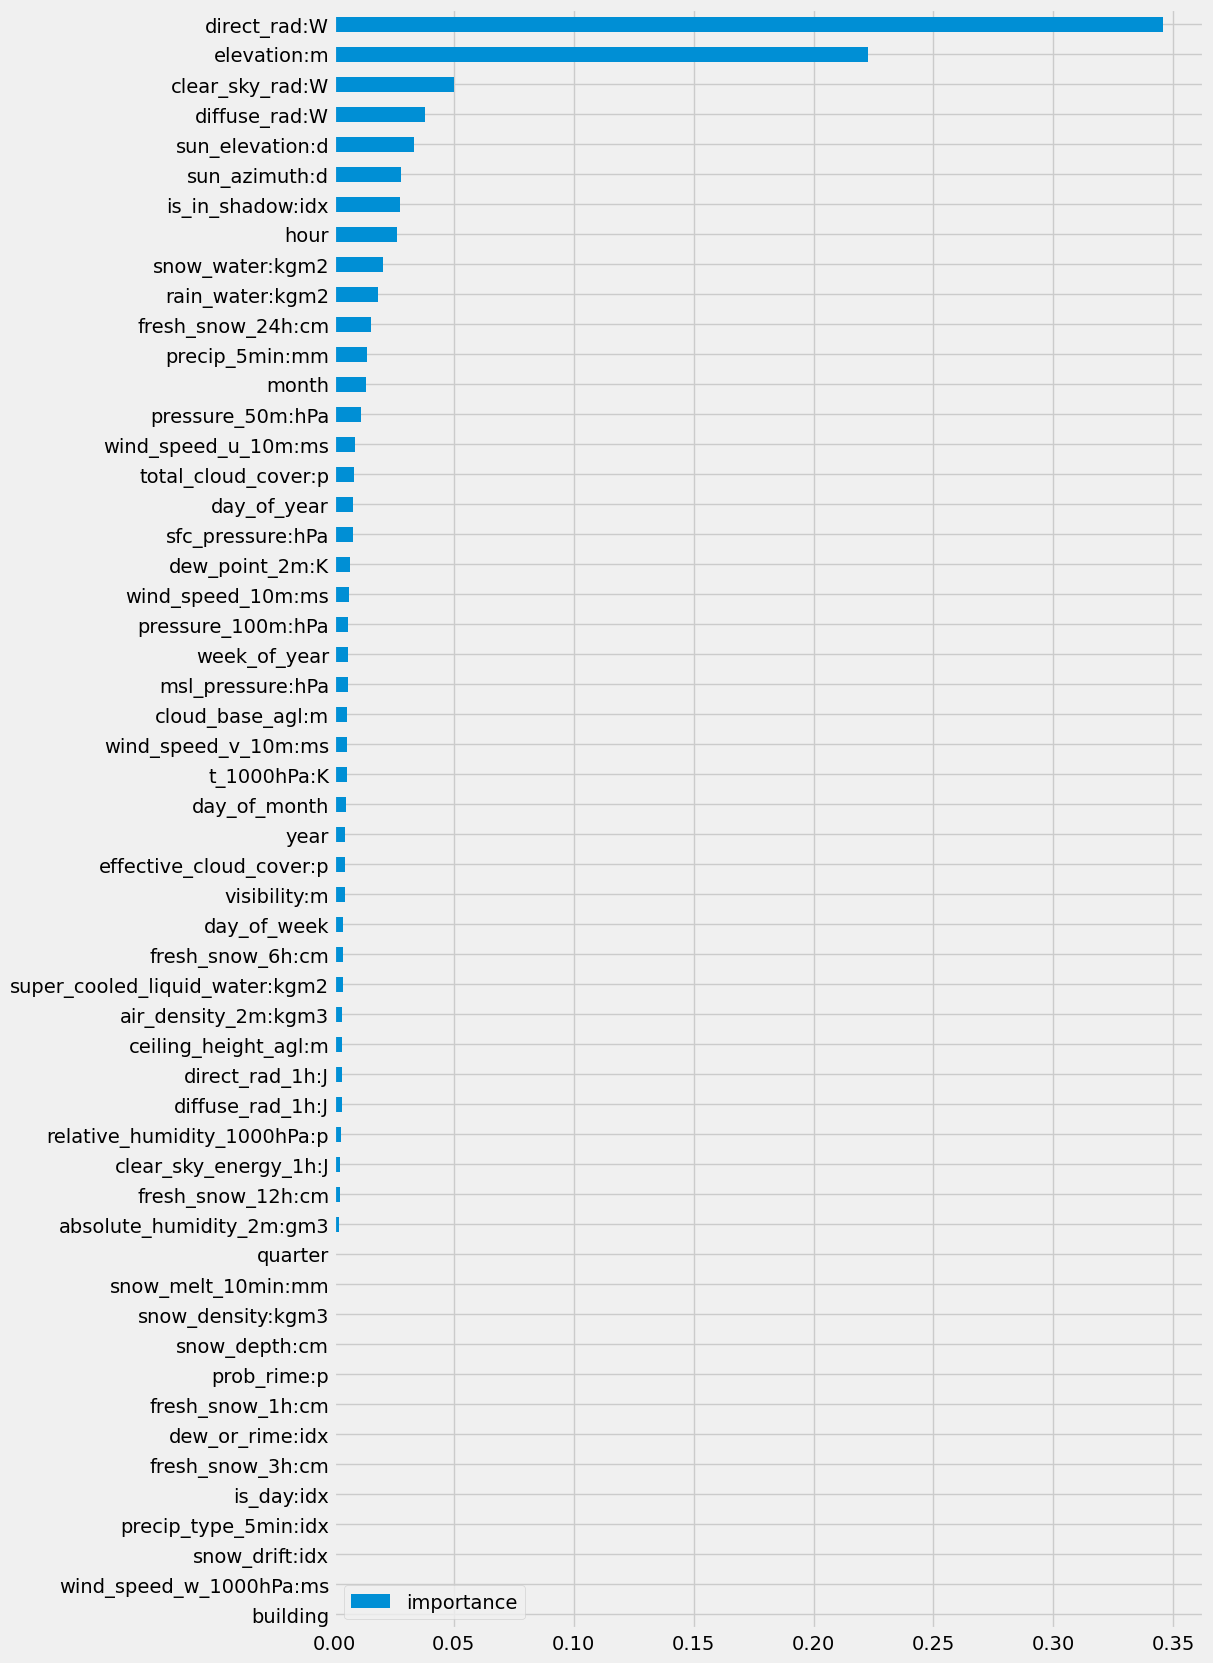

In [329]:
fi.sort_values(by='importance').plot(kind='barh', figsize=(10,20))

<Axes: >

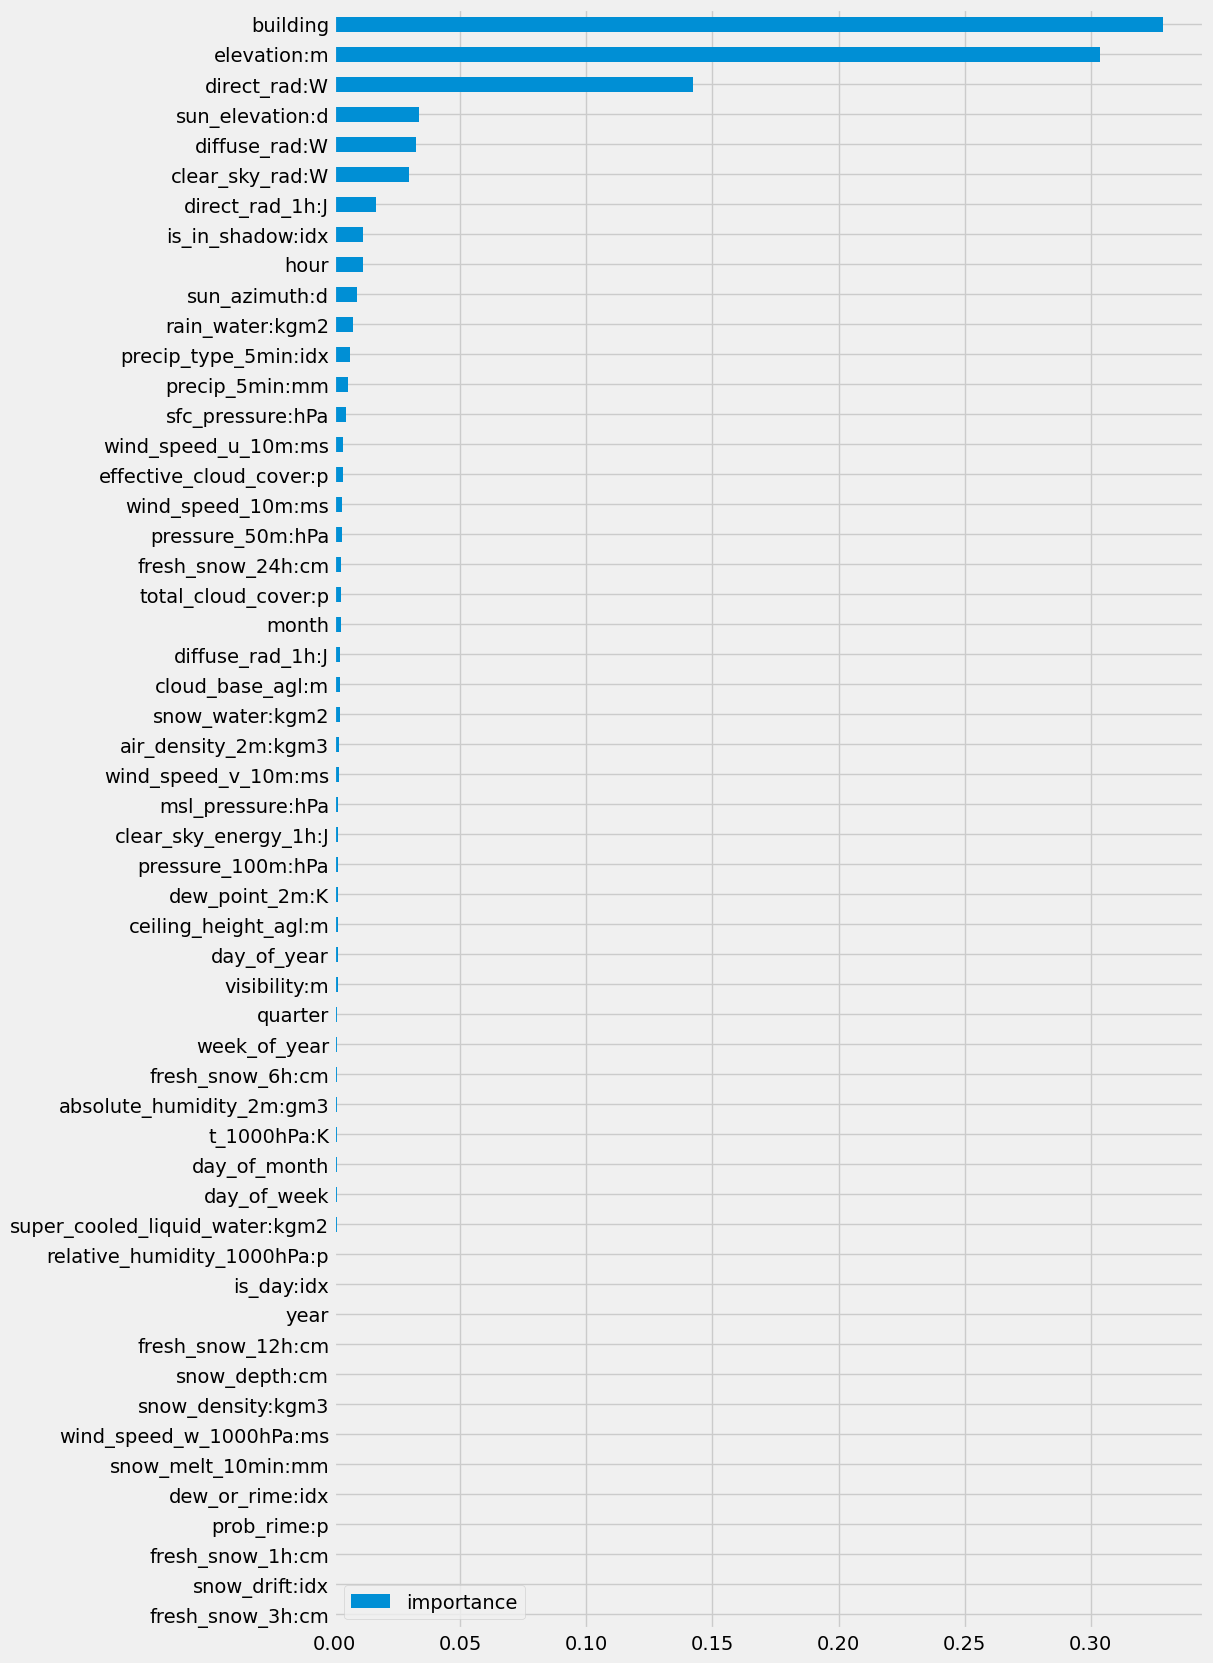

In [270]:
fi2 = pd.DataFrame(data=best_xgb_model.feature_importances_,
                  index=best_xgb_model.feature_names_in_,
                  columns=['importance'])
fi2.sort_values(by='importance').plot(kind='barh', figsize=(10,20))

### Test with combined data from each building

In [ ]:
res = reg.predict(test[FEATURES])

In [272]:
def create_results_dataframe(test, y_pred):
    results = test.copy()
    results = results[['hour', 'day_of_week', 'quarter', 'month', 'year', 'day_of_year', 'day_of_month', 'week_of_year', 'building']]
    res_pd = pd.DataFrame(data=y_pred, index=test.index, columns=['pv_prediction'])
    results["pv_prediction"] = pd.DataFrame(data=res_pd)
    return results

In [273]:
results1 = create_results_dataframe(test, res)
results2 = create_results_dataframe(test, y_pred)

In [274]:
# make a function of this
def plot_results_daily(train,results):
    fig, ax = plt.subplots(figsize=(12,8))
    sns.lineplot(data=results[results['building'] == 0], x='day_of_month', y='pv_prediction', label='pv_prediction (building A)')
    sns.lineplot(data=results[results['building'] == 1], x='day_of_month', y='pv_prediction', label='pv_prediction (building B)')
    sns.lineplot(data=results[results['building'] == 2], x='day_of_month', y='pv_prediction', label='pv_prediction (building C)')
    sns.lineplot(data=train[train['building'] == 0], x='day_of_month', y='pv_measurement', label='pv_measured (building A) 2021')
    sns.lineplot(data=train[train['building'] == 1], x='day_of_month', y='pv_measurement', label='pv_measured (building B) 2021')
    sns.lineplot(data=train[train['building'] == 2], x='day_of_month', y='pv_measurement', label='pv_measured (building C) 2021')
    ax.set_title('daily pv_prediction and pv_measurement between May 1st and July 5th')
    ax.set_ylabel('pv_measurement')
    ax.set_xlabel('day_of_month')
    ax.legend()

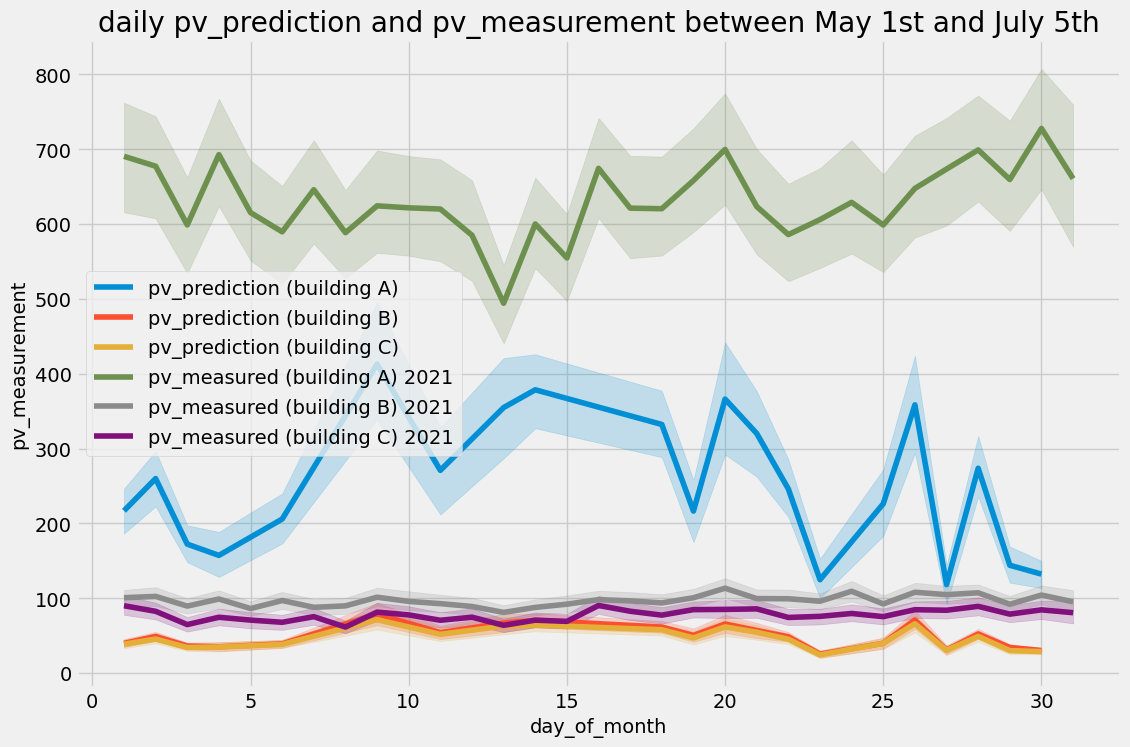

In [290]:
plot_results_daily(train, results2)

In [287]:
# make a function of this, but make it optional how many years to plot (also make the lines easy to distinguish)
def plot_results_hourly(train,results, years=2):

    # remove NaN values from pv_measurement in train and slice it so that it ranges from May 1st to July 5th 2021
    train_copy = train[~train['pv_measurement'].isna()]
    train_copy_2022 = train_copy.loc['2022-05-01':'2022-07-05']
    train_copy_2021 = train_copy.loc['2021-05-01':'2021-07-05']
    train_copy_2020 = train_copy.loc['2020-05-01':'2020-07-05']
    train_copy_2019 = train_copy.loc['2019-05-01':'2019-07-05']

    train_list = [train_copy_2019, train_copy_2020, train_copy_2021, train_copy_2022]
    # slice the list so that it only contains the number of years specified in the years parameter
    train_list = train_list[-years:]

    # print(train_list)

    for train_year in train_list:
        fig, ax = plt.subplots(figsize=(12,8))
        sns.lineplot(data=results[results['building'] == 0], x='hour', y='pv_prediction', label='pv_prediction (building A)')
        sns.lineplot(data=results[results['building'] == 1], x='hour', y='pv_prediction', label='pv_prediction (building B)')
        sns.lineplot(data=results[results['building'] == 2], x='hour', y='pv_prediction', label='pv_prediction (building C)')
        sns.lineplot(data=train_year[train_year['building'] == 0], x='hour', y='pv_measurement', label=f'pv_measured (building A) {train_year.index.year[0]}')
        sns.lineplot(data=train_year[train_year['building'] == 1], x='hour', y='pv_measurement', label=f'pv_measured (building B) {train_year.index.year[0]}')
        sns.lineplot(data=train_year[train_year['building'] == 2], x='hour', y='pv_measurement', label=f'pv_measured (building C) {train_year.index.year[0]}')
    
    ax.set_title('hour pv_prediction and pv_measurement between May 1st and July 5th')
    ax.set_ylabel('pv_measurement')
    ax.set_xlabel('hour')
    ax.legend()

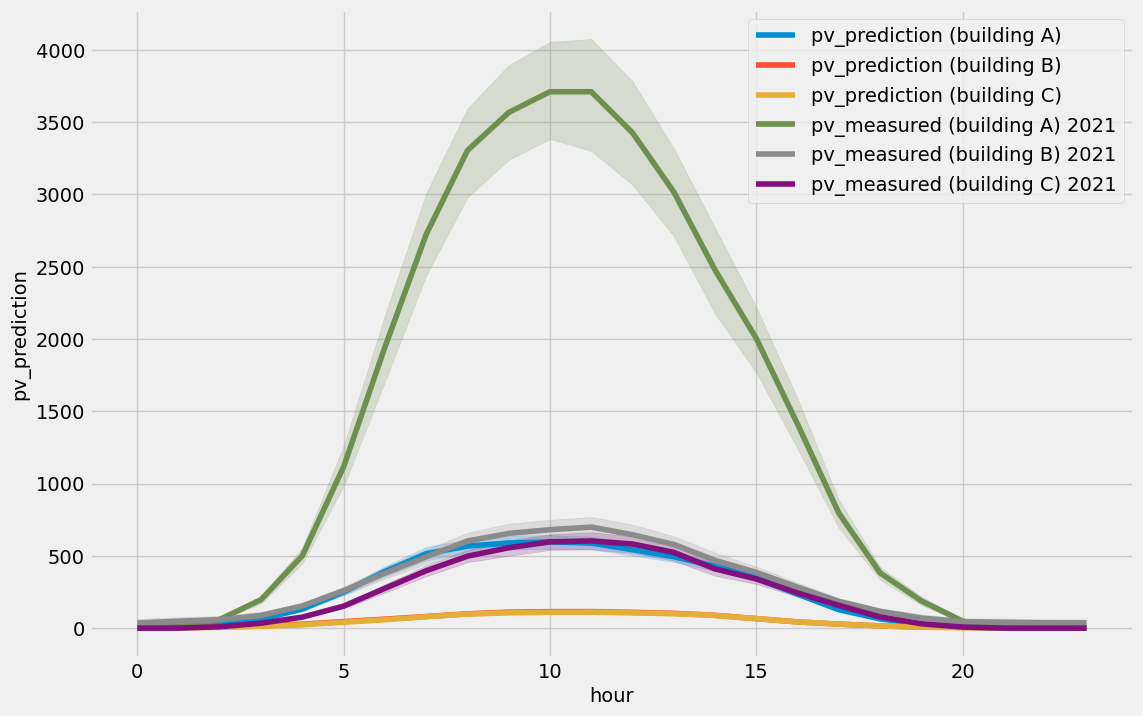

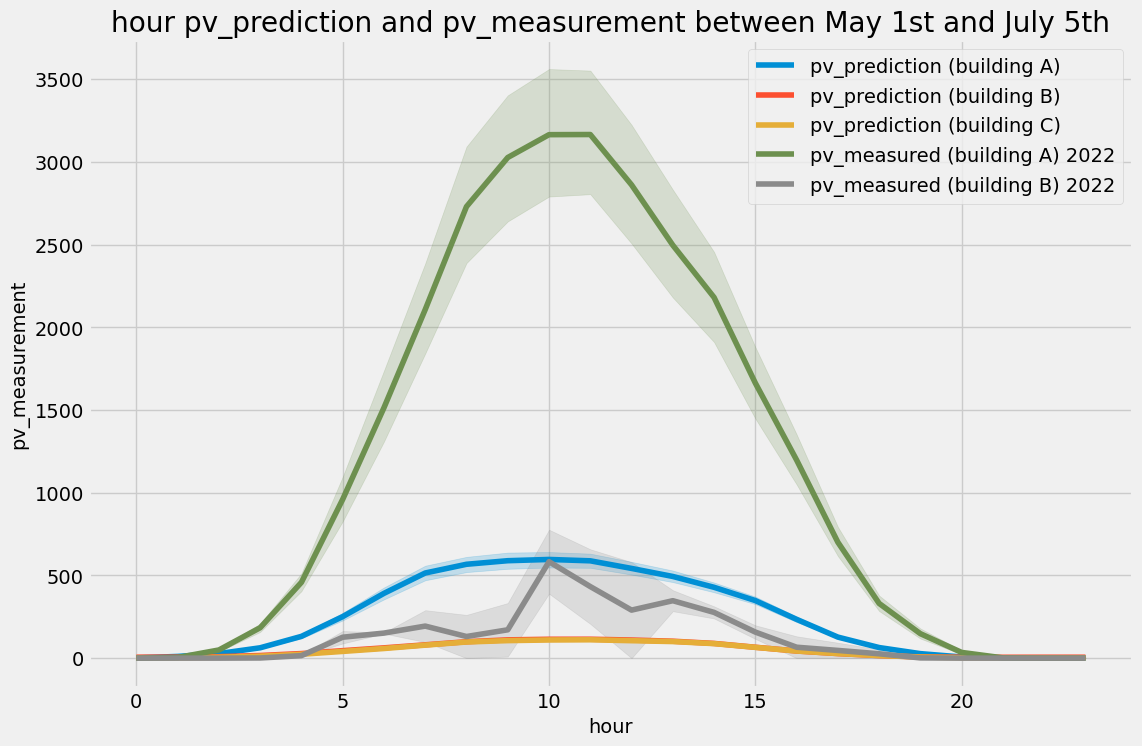

In [288]:
plot_results_hourly(train, results2, years=2)

### Save model for later comparison

In [58]:
reg.save_model('models/10_01_model_1.json')

### Save results to cvs

In [295]:
results2

,hour,day_of_week,quarter,month,year,day_of_year,day_of_month,week_of_year,building,pv_prediction
date_forecast,,,,,,,,,,
2023-05-01 00:00:00,0,0,2,5,2023,121,1,18,0,0.604155
2023-05-01 00:00:00,0,0,2,5,2023,121,1,18,1,0.604155
2023-05-01 00:00:00,0,0,2,5,2023,121,1,18,2,0.590880
2023-05-01 00:15:00,0,0,2,5,2023,121,1,18,0,0.604155
2023-05-01 00:15:00,0,0,2,5,2023,121,1,18,1,0.604155
...,...,...,...,...,...,...,...,...,...,...
2023-07-03 23:30:00,23,0,3,7,2023,184,3,27,0,0.800310
2023-07-03 23:30:00,23,0,3,7,2023,184,3,27,1,6.493257
2023-07-03 23:45:00,23,0,3,7,2023,184,3,27,1,6.493257


In [324]:
# make a function of this
def save_to_csv(results, filename):
    # slice the results dataframe so that it contains rows where minute is 0
    results = results[results.index.minute == 0]
    results = results[['pv_prediction']]
    results.rename(columns={'pv_prediction': 'prediction'}, inplace=True)
    #reset the index
    results.reset_index(inplace=True)
    #emove date_forecast column
    results.drop(columns=['date_forecast'], inplace=True)
    #rename the index column to "id"
    results['id'] = results.index
    #move the id column to the first column
    cols = list(results.columns)
    cols = [cols[-1]] + cols[:-1]
    results = results[cols]
    #save to csv
    results.to_csv(f'results/{filename}.csv', index=False)
    print(results.head())

In [325]:
save_to_csv(results2, "results2")

   id  prediction
0   0    0.604155
1   1    0.604155
2   2    0.590880
3   3    0.590880
4   4    0.604155
